# Tanzania Water Resources
## 2. Pipelines

Importing the required packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import pickle #To save the objects 
import pprint
from lxml import html
import requests
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from urllib.request import urlopen
from bs4 import BeautifulSoup
from IPython.display import HTML
import re
import urllib
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the data
We are given the following data sets:
* training_data.csv (Contains the training data)
* training_labels.csv (Contains the target labels)
* test_data.csv (test data)

Let us read training_data.csv and training_labels.csv, and combine them to form a single data frame. The combined training data will help us to perform the EDA easily.

In [2]:
training_values = pd.read_csv('training_data.csv')
training_labels = pd.read_csv('training_labels.csv')

In [3]:
display(training_values.head())
training_values.shape

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


(59400, 40)

In [4]:
display(training_labels.head())
training_labels.shape

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


(59400, 2)

Let us combine the training_labels and training_values, to form training_data dataframe.

In [5]:
training_values.index = list(training_values['id'])
training_labels.index = list(training_labels['id'])
training_values.drop(["id"],axis=1,inplace=True)
training_labels.drop(["id"],axis=1,inplace=True)

training_data=training_values.join(training_labels,
                     how='inner',lsuffix='_values', 
                     rsuffix='labels')
training_data.shape

(59400, 40)

## Splitting the data into test/train data

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
X = training_data.drop('status_group',axis=1)
y = training_data['status_group']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
df = X_train
df['status_group'] = y_train

In [8]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [9]:
#sum(y_train.isnull())

## Pipelines

In EDA, we decided to use Std. Scaler for amount_tsh column.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelBinarizer, Imputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import re

#This will help us to select the desired columns of a data frame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names]

class HandleCategorical(BaseEstimator, TransformerMixin):
    def __init__(self,substitute='unknown',convert_to_small='y'):
        '''
           cols must be a list
        '''
        self.substitute = substitute
        self.convert_to_small = convert_to_small
        #self.cols = cols
    def get_alpha_numeric(self,x):
        y = list()
        for i in list(x):
            temp = re.sub(r'[^a-zA-Z0-9]',' ', i)
            temp = re.sub(' +'," ",temp)
            y.append(temp)
        return y
    def fit(self,X, y=None):
        return self
    def transform(self,X):
        X=X.fillna(self.substitute)
        if self.convert_to_small == 'y':
            X = X.apply(lambda x: x.astype(str).str.lower())
            #Include only alpha-numeric chars
            #Remove any contiguous spaces    
            for i in X.columns:
                X[i] = self.get_alpha_numeric(X[i])
        return X
#For funder, we need to 

In [11]:
numeric_columns = ['amount_tsh']
categorical_columns = ['funder','installer','wpt_name']
num_pipeline = Pipeline([ \
                         ('selector',DataFrameSelector(numeric_columns)), \
                         ('imputer', Imputer(strategy="median")), \
                         ('std_scaler',StandardScaler()) \
                        ])
num_pipeline.fit(df)
num_pipeline.fit_transform(df)

cat_pipeline = Pipeline([ \
                         ('selector',DataFrameSelector(categorical_columns)), \
                         ('catnullhandler',HandleCategorical())
                        ])


In [12]:
df['funder'] = list(cat_pipeline.fit_transform(df)['funder'])
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
72938,0.0,2011-07-27,unknown,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
65358,500.0,2011-03-23,rc church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
469,25.0,2011-03-07,donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
1298,0.0,2011-07-31,government of tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
27001,0.0,2011-03-10,water,0,Gove,35.389331,-6.399942,Chama,0,Internal,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [13]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

funder_dict = {"government of tanzania": "tanzania government",
              "unknown":"unknown",
              "danida":"denmark",
              "hesawa":"hesawa",
              "world bank":"world bank",
              "rwssp":"rwssp",
              "kkkt":"kkkt",
              "acord":"acord",
              #"church":"church", 
              # "baptist":"church",
              "world vision":"world vision",
              "unicef":"unicef",
              "tasaf":"tasaf",
              "district council":"tanzania district government",
              "private individual":"unknown",
               "community":"local community",
               "dhv":"dhv",
               "dwsp":"dwsp",
               "norad":"netherlands",
               "0": "unknown",
               "germany":"germany",
               "tcrs":"tcrs",
               "ministry of water":"ministry of water",
               #"water":"ministry of water",
               "netherlands":"netherlands",
               "dwe":"tanzania government",
               "adb":"african development bank",
               "african development bank":"african development bank",
               "lga":"tanzania local government",
               "hifab":"hifab",
               "urban water supply and sanitation project for zanzibar":"african development bank",
               "rural water supply and sanitation":"african development bank",
               "nsgrp":"tanzania government",
               "monduli district water":"african development bank"
               }

#Create another column funder_new.
#Populate this as follows:
#For each value in funder, if there is an exact match with a key in above dict, then use the value of the above dict
#If there is NO match, then use values of the above dict, and perform fuzzy match
#If there is a match with a score of 80 or more, then use the value, else use "other"
#Finally we will replace funder with funder_new

#funder_dict['sekhar']
def find_and_replace(l,map_dict):
    funder_new = []
    for j in list(l):
        try:
            funder_new.append(map_dict[str(j).lower()])
            continue
        except:
            word,score = process.extract(j, map_dict.keys(), limit=1)[0]

            if score > 85:
                funder_new.append(map_dict[word])
            else:
                funder_new.append(j)
    return funder_new        
funder_new = find_and_replace(df['funder'],funder_dict)


In [14]:
df['funder_new'] = funder_new    

In [15]:
df[['funder','funder_new']]

,funder,funder_new
72938,unknown,unknown
65358,rc church,rc church
469,donor,donor
1298,government of tanzania,tanzania government
27001,water,ministry of water
41546,dwe norad,netherlands
16230,oxfam,oxfam
10307,water,ministry of water
37145,danida,denmark
49234,tancan,tancan


In [144]:
def get_group_split(df,col):
    '''
       df = Data Frame, along with the status_group variable
       col = categorical variable
    '''
 
    #Get the total pumps at the given col level
    total_count=df.groupby([col]).size().reset_index()
    total_count.columns=[col,'total']
    total_count.index = total_count[col]
    total_count = total_count.drop([col],axis=1)

    #display(total_count.head())

    status_count = df.groupby([col,'status_group']).size().reset_index()
    status_count.columns=[col,'status_group','status_total']
    status_count.index = status_count[col]
    status_count = status_count.drop([col],axis=1)
    #display(status_count.head())
    joined_df = total_count.join(status_count,how='left')

    joined_df['proportion'] = joined_df['status_total']/joined_df['total']
    
    #display(joined_df.head())
    return joined_df[['status_group','proportion']]


In [147]:
find_and_replace(['aco germany'],funder_dict)

['germany']

In [150]:
temp_df=get_group_split(df,'funder_new')
temp_df=temp_df.reset_index()
funder_probabilities = pd.pivot_table(temp_df,values='proportion',columns='status_group',index='funder_new')
funder_probabilities

status_group,functional,functional needs repair,non functional
funder_new,,,
aar,0.640000,0.120000,0.240000
abas ka,1.000000,NaN,NaN
abasia,0.866667,0.066667,0.066667
abd,0.714286,NaN,0.285714
abdul,NaN,NaN,1.000000
abood,NaN,NaN,1.000000
acord,0.642857,0.051020,0.306122
acra,1.000000,NaN,NaN
act,1.000000,NaN,NaN


In [152]:
funder_probabilities.fillna(0,inplace=True)

In [153]:
funder_probabilities.head()

status_group,functional,functional needs repair,non functional
funder_new,,,
aar,0.640000,0.120000,0.240000
abas ka,1.000000,0.000000,0.000000
abasia,0.866667,0.066667,0.066667
abd,0.714286,0.000000,0.285714
abdul,0.000000,0.000000,1.000000


In [154]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2,copy=True,random_state=42)
pca.fit(funder_probabilities)


# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(funder_probabilities)

# TODO: Transform log_samples using the PCA fit above
#pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])


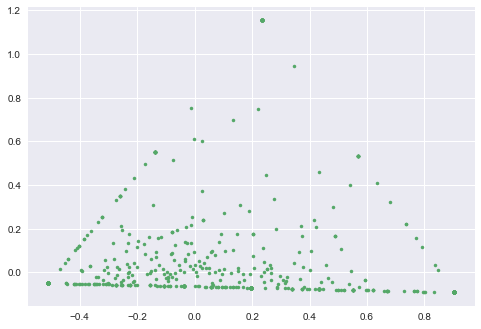

In [164]:
plt.plot(reduced_data['Dimension 1'],reduced_data['Dimension 2'],linestyle='none',marker='.')
plt.show()
#reduced_data